In [1]:
import os  # Import the os module to use listdir

# Update the data path to your local path
data_path = '/home/labadmin/multiPLD/mridata_new'

# Check if the directory exists
if os.path.exists(data_path):
    print(f"Path '{data_path}' exists.")
    # List the files in the directory
    files = os.listdir(data_path)  # Get the list of files
    if files:
        print("Files in dataset folder:", files)
    else:
        print("The folder is empty.")
else:
    print(f"Path '{data_path}' does not exist. Please check the directory path.")



Path '/home/labadmin/multiPLD/mridata_new' exists.
Files in dataset folder: ['index3_subject_17_noisy.mat', 'index3_subject_23_noisy.mat', 'index3_subject_21_noisy.mat', 'index3_subject_4_noisy.mat', 'index3_subject_2_noisy.mat', 'index3_subject_7_noisy.mat', 'index3_subject_12_noisy.mat', 'index3_subject_3_noisy.mat', 'index3_subject_14_noisy.mat', 'index3_subject_8_noisy.mat', 'index3_subject_13_noisy.mat', 'index3_subject_5_noisy.mat', 'index3_subject_6_noisy.mat', 'index3_subject_1_noisy.mat', 'index3_subject_19_noisy.mat', 'index3_subject_11_noisy.mat', 'index3_subject_20_noisy.mat', 'index3_subject_16_noisy.mat', 'index3_subject_10_noisy.mat', 'index3_subject_18_noisy.mat', 'index3_subject_24_noisy.mat', 'index3_subject_15_noisy.mat', 'index3_subject_9_noisy.mat', 'index3_subject_22_noisy.mat']


In [2]:
# Function to load and preprocess data
def load_and_preprocess_hdf5(file_path):
    with h5py.File(file_path, 'r') as file:
        data_group = file['data_phantom_noisy']

        # Load datasets
        pwi = np.array(data_group['PWI_images'])  # Shape: (3, 60, 60, 72)
        cbf = np.array(data_group['CBF_groundtruth'])  # Shape: (60, 60, 72)
        att = np.array(data_group['ATT_groundtruth'])  # Shape: (60, 60, 72)

        # Transpose PWI to match (batch, height, width, channels)
        pwi = np.transpose(pwi, (1, 2, 3, 0))

        # Normalize PWI, CBF, and ATT
        pwi = (pwi - np.min(pwi)) / (np.max(pwi) - np.min(pwi))
        cbf = (cbf - np.min(cbf)) / (np.max(cbf) - np.min(cbf))
        att = (att - np.min(att)) / (np.max(att) - np.min(att))

    return pwi, cbf, att

In [3]:
import os
import numpy as np
import h5py

# Load and preprocess data

pwi_subjects, cbf_subjects, att_subjects = [], [], []
for file_name in files:
    file_path = os.path.join(data_path, file_name)
    pwi, cbf, att = load_and_preprocess_hdf5(file_path)
    pwi_subjects.append(pwi)
    cbf_subjects.append(cbf)
    att_subjects.append(att)

In [4]:
# Convert lists to numpy arrays
pwi_subjects = np.array(pwi_subjects)
cbf_subjects = np.array(cbf_subjects)
att_subjects = np.array(att_subjects)

In [5]:
import numpy as np
import sklearn
print("NumPy version:", np.__version__)
print("Scikit-learn version:", sklearn.__version__)


NumPy version: 1.23.5
Scikit-learn version: 1.2.2


In [10]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train_cbf, y_test_cbf, y_train_att, y_test_att = train_test_split(
    pwi_subjects, cbf_subjects, att_subjects, test_size=4/24, random_state=42
)

# Print shapes for verification
print("Training PWI shape:", X_train.shape)
print("Testing PWI shape:", X_test.shape)
print("Training CBF shape:", y_train_cbf.shape)
print("Testing CBF shape:", y_test_cbf.shape)
print("Training ATT shape:", y_train_att.shape)
print("Testing ATT shape:", y_test_att.shape)


Training PWI shape: (20, 60, 60, 72, 3)
Testing PWI shape: (4, 60, 60, 72, 3)
Training CBF shape: (20, 60, 60, 72)
Testing CBF shape: (4, 60, 60, 72)
Training ATT shape: (20, 60, 60, 72)
Testing ATT shape: (4, 60, 60, 72)


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Transformer Block
def transformer_block(x, num_heads=4, ff_dim=128):
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=x.shape[-1])(x, x)
    x = layers.Add()([x, attn_output])
    x = layers.LayerNormalization()(x)

    ffn = layers.Dense(ff_dim, activation='relu')(x)
    ffn = layers.Dense(x.shape[-1])(ffn)
    x = layers.Add()([x, ffn])
    x = layers.LayerNormalization()(x)

    return x

# Define CNN-Transformer Hybrid Model
def cnn_transformer_model(input_shape, num_heads=4, transformer_layers=2):
    inputs = layers.Input(shape=input_shape)

    # CNN Feature Extractor
    x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
    p1 = layers.MaxPooling3D((2, 2, 2))(x)

    x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(p1)
    x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
    p2 = layers.MaxPooling3D((2, 2, 2))(x)

    x = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(p2)
    x = layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(x)

    # Reshape for Transformer Input (Fixed)
    x = layers.Reshape((x.shape[1] * x.shape[2] * x.shape[3], x.shape[-1]))(x)

    # Transformer Layers
    for _ in range(transformer_layers):
        x = transformer_block(x, num_heads=num_heads)

    # Output Processing
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)

    # Output heads with fixed shape
    output_cbf = layers.Dense(60 * 60 * 72, activation='linear', name="CBF")(x)
    output_cbf = layers.Reshape((60, 60, 72, 1))(output_cbf)

    output_att = layers.Dense(60 * 60 * 72, activation='linear', name="ATT")(x)
    output_att = layers.Reshape((60, 60, 72, 1))(output_att)

    model = Model(inputs, [output_cbf, output_att])
    return model

# Initialize the model
model = cnn_transformer_model(input_shape=(60, 60, 72, 3))

# SSIM and PSNR metrics functions
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def psnr_loss(y_true, y_pred):
    return tf.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1.0))

def accuracy_metric(y_true, y_pred, threshold=0.5):
    if y_pred.shape[-1] == 1:  # Only squeeze if last dimension is 1
        y_pred = tf.squeeze(y_pred, axis=-1)

    y_pred = tf.cast(y_pred > threshold, tf.float32)  # Apply threshold
    correct = tf.equal(y_true, y_pred)
    return tf.reduce_mean(tf.cast(correct, tf.float32))


def ssim_metric(y_true, y_pred):
    # Ensure y_pred has the correct shape before computing SSIM
    if y_pred.shape[-1] == 1:  # Only squeeze if the last dimension is 1
        y_pred = tf.squeeze(y_pred, axis=-1)

    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def psnr_metric(y_true, y_pred):
    # Ensure y_pred has the correct shape before processing
    if y_pred.shape[-1] == 1:
        y_pred = tf.squeeze(y_pred, axis=-1)  # Squeeze only if last dim is 1

    return tf.image.psnr(y_true, y_pred, max_val=1.0)

# Lin's Concordance Correlation Coefficient (CCC)
def ccc_metric(y_true, y_pred):
    # Flatten the tensors to 1D arrays for computation
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])

    # Mean of the true and predicted values
    mean_true = tf.reduce_mean(y_true_flat)
    mean_pred = tf.reduce_mean(y_pred_flat)

    # Covariance between true and predicted
    covariance = tf.reduce_mean((y_true_flat - mean_true) * (y_pred_flat - mean_pred))

    # Variance of the true and predicted values
    var_true = tf.reduce_mean(tf.square(y_true_flat - mean_true))
    var_pred = tf.reduce_mean(tf.square(y_pred_flat - mean_pred))

    # Calculate CCC
    ccc = (2 * covariance) / (var_true + var_pred + tf.square(mean_true - mean_pred))

    return ccc


In [13]:
print(model.output_names)


['reshape_4', 'reshape_5']


In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss={'reshape_4': 'mean_squared_error', 'reshape_5': 'mean_squared_error'},
    metrics={
        'reshape_4': ['mse', ssim_metric, psnr_metric, accuracy_metric, ccc_metric],
        'reshape_5': ['mse', ssim_metric, psnr_metric, accuracy_metric, ccc_metric]
    }
)


# Train the model
history = model.fit(
    X_train, [y_train_cbf, y_train_att],
    validation_data=(X_test, [y_test_cbf, y_test_att]),
    epochs=15,
    batch_size=2,
    verbose=1
)

Epoch 1/15


2025-04-09 06:54:26.501600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8905
2025-04-09 06:54:26.801540: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-04-09 06:54:26.851134: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fe4ec002a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-09 06:54:26.851151: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-04-09 06:54:26.867114: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-09 06:54:27.008630: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

10/10 [==============================] - 6s 129ms/step - loss: 0.2576 - reshape_4_loss: 0.1312 - reshape_5_loss: 0.1264 - reshape_4_mse: 0.1312 - reshape_4_ssim_metric: 0.3301 - reshape_4_psnr_metric: 8.9825 - reshape_4_accuracy_metric: 0.7066 - reshape_4_ccc_metric: 0.0196 - reshape_5_mse: 0.1264 - reshape_5_ssim_metric: 0.3332 - reshape_5_psnr_metric: 9.1149 - reshape_5_accuracy_metric: 0.7066 - reshape_5_ccc_metric: 0.0172 - val_loss: 0.2312 - val_reshape_4_loss: 0.1039 - val_reshape_5_loss: 0.1274 - val_reshape_4_mse: 0.1039 - val_reshape_4_ssim_metric: 0.2235 - val_reshape_4_psnr_metric: 9.9277 - val_reshape_4_accuracy_metric: 0.7066 - val_reshape_4_ccc_metric: 0.0727 - val_reshape_5_mse: 0.1274 - val_reshape_5_ssim_metric: 0.2168 - val_reshape_5_psnr_metric: 9.0236 - val_reshape_5_accuracy_metric: 0.7066 - val_reshape_5_ccc_metric: 0.0655
Epoch 2/15
10/10 [==============================] - 1s 52ms/step - loss: 0.2197 - reshape_4_loss: 0.1117 - reshape_5_loss: 0.1080 - reshape_4_m

In [15]:
evaluation = model.evaluate(X_test, [y_test_cbf, y_test_att], verbose=1)
print("Evaluation Results:", evaluation)

# Extract the metrics from evaluation results
# Corrected mapping of metric names to evaluation results
metrics_names = [
    "Total_Loss", "CBF_Loss", "ATT_Loss",
    "CBF_MSE", "CBF_SSIM", "CBF_PSNR", "CBF_Accuracy", "CBF_CCC",
    "ATT_MSE", "ATT_SSIM", "ATT_PSNR", "ATT_Accuracy", "ATT_CCC"
]

# Print metrics in a readable format
print("\nFinal Evaluation Metrics:")
for name, value in zip(metrics_names, evaluation):
    print(f"{name}: {value:.4f}")


# Print metrics in a readable format
print("\nFinal Evaluation Metrics:")
for name, value in zip(metrics_names, evaluation):
    print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 1s/step - loss: 0.0208 - reshape_4_loss: 0.0143 - reshape_5_loss: 0.0065 - reshape_4_mse: 0.0143 - reshape_4_ssim_metric: 0.7860 - reshape_4_psnr_metric: 19.1037 - reshape_4_accuracy_metric: 0.7213 - reshape_4_ccc_metric: 0.9219 - reshape_5_mse: 0.0065 - reshape_5_ssim_metric: 0.8815 - reshape_5_psnr_metric: 22.2162 - reshape_5_accuracy_metric: 0.7149 - reshape_5_ccc_metric: 0.9668
Evaluation Results: [0.02075803466141224, 0.014255625195801258, 0.006502408999949694, 0.014255625195801258, 0.785983145236969, 19.103687286376953, 0.7212731242179871, 0.9218564629554749, 0.006502408999949694, 0.8814979791641235, 22.216167449951172, 0.7149016261100769, 0.9667540192604065]

Final Evaluation Metrics:
Total_Loss: 0.0208
CBF_Loss: 0.0143
ATT_Loss: 0.0065
CBF_MSE: 0.0143
CBF_SSIM: 0.7860
CBF_PSNR: 19.1037
CBF_Accuracy: 0.7213
CBF_CCC: 0.9219
ATT_MSE: 0.0065
ATT_SSIM: 0.8815
ATT_PSNR: 22.2162
ATT_Accuracy: 0.7149
ATT_CCC: 0.9668

Final Evaluation Metrics:
T

1/1 [==============================] - 0s 369ms/step


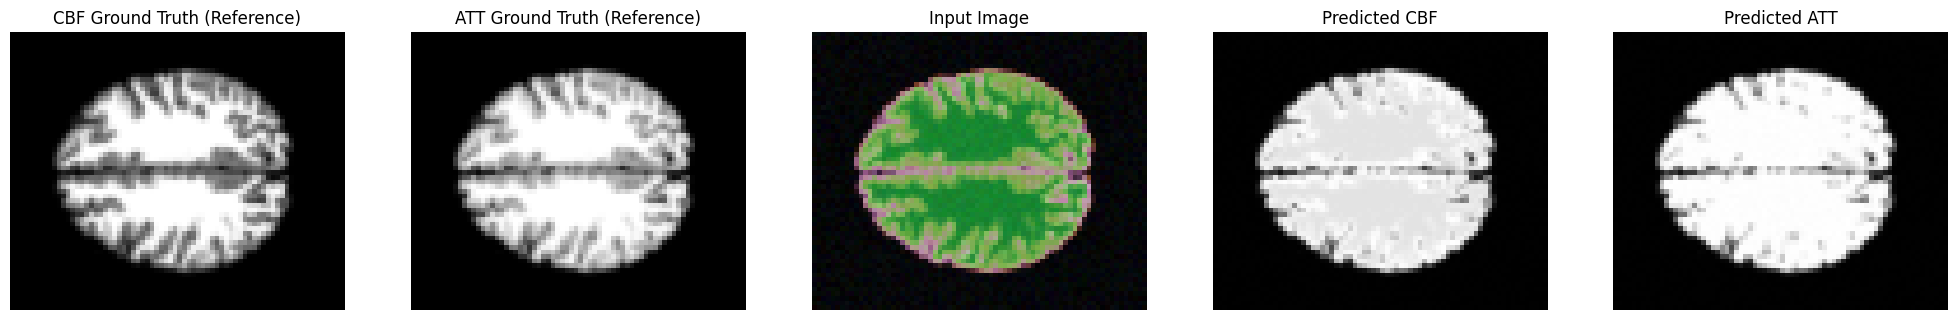

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Select the index of the test subject (example: index 0, slice 23)
test_subject_index = 0
slice_index = 23

# Get the input image for the chosen test subject and slice
input_image = X_test[test_subject_index][slice_index]

# Ensure input image is in the range [0, 1] for display (normalize if needed)
input_image = np.clip(input_image, 0, 1)

# Get the ground truth CBF and ATT images for the chosen test subject and slice
cbf_ground_truth = y_test_cbf[test_subject_index][slice_index]
att_ground_truth = y_test_att[test_subject_index][slice_index]

# Predict the output using the trained model
cbf_pred, att_pred = model.predict(np.expand_dims(X_test[test_subject_index], axis=0))

# Extract the predicted CBF and ATT for the chosen slice
cbf_pred_slice = cbf_pred[0][slice_index]
att_pred_slice = att_pred[0][slice_index]

# Create a plot to show the reference image, input image, and output CBF and ATT
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

# Plot reference CBF image (ground truth CBF)
axes[0].imshow(cbf_ground_truth, cmap='gray', interpolation='none')
axes[0].set_title('CBF Ground Truth (Reference)')
axes[0].axis('off')

# Plot reference ATT image (ground truth ATT)
axes[1].imshow(att_ground_truth, cmap='gray', interpolation='none')
axes[1].set_title('ATT Ground Truth (Reference)')
axes[1].axis('off')

# Plot input image (now in greyscale)
axes[2].imshow(input_image, cmap='gray', interpolation='none')
axes[2].set_title('Input Image')
axes[2].axis('off')

# Plot predicted CBF image
axes[3].imshow(cbf_pred_slice, cmap='gray', interpolation='none')
axes[3].set_title('Predicted CBF')
axes[3].axis('off')

# Plot predicted ATT image
axes[4].imshow(att_pred_slice, cmap='gray', interpolation='none')
axes[4].set_title('Predicted ATT')
axes[4].axis('off')

plt.show()
